In [1]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *
from code_generation import *
from graph_grammar import *
from models_and_guides import *
from inference import *
from plotting import *

In [2]:
%load_ext autoreload

%autoreload 2

## Define graph for factor model

In [3]:
factor = nx.DiGraph()

In [4]:
nodes = [
    #('z_loc',{'type':'const', 'value':0.}),
    #('z_scale',{'type':'const', 'value':1.}),
    ('z_loc',{'type':'function', 'function':torch.zeros, 'args':(Name(id='K'),)}),
    ('z_scale',{'type':'function', 'function':torch.ones, 'args':(Name(id='K'),)}),
    ('z',{'distribution':dist.Normal,'type':'latent','event_dims':1}),
    #('z_T',{'type':'deterministic', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    #('z_T',{'type':'function', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
#    ('cov_factor_loc',{'type':'param','shape':'KD'}),
#    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'DK'}),
    ('cov_factor_scale',{'type':'param','shape':'DK','constraint':'positive'}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent','event_dims':2}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'function', 'function':torch.matmul, 'args':('p','t')}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent','event_dims':1}),
    ('cov_diag_j',{'type':'function', 'function':torch.add, 'args':('p',Num(n=0.0001))}),
    #('diag',{'type':'deterministic', 'function':torch.diag_embed}),
    ('diag',{'type':'function', 'function':torch.diag_embed}),
]

In [5]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
#    ('z','z_T',{'type':'arg'}),
#    ('z_T','Wz',{'type':'arg'}),
    ('z','Wz',{'type':'arg'}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','cov_diag_j',{'type':'arg'}),
    ('cov_diag_j','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'covariance_matrix'})
]

In [6]:
plate_attr = {
#    'cov_factor':{'plates':['D','K']},
#    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    #'z':{'plates':['N','K']},
    'z':{'plates':['N']},
    #'z_T':{'plates':['N']}
}

In [7]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


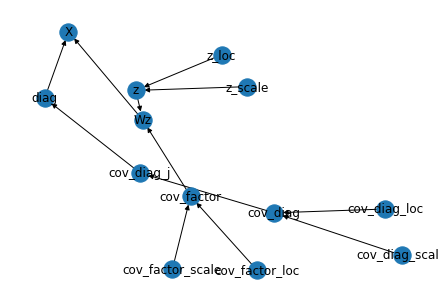

In [8]:
nx.draw(factor, with_labels=True)

## Marginalize latent variables out

In [9]:
marg_factor = marginalize_factor(factor)

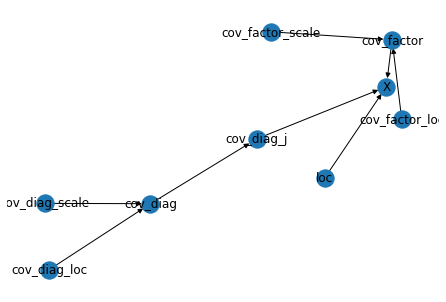

In [10]:
nx.draw(marg_factor, with_labels=True)

### Create graph and code for mixture of factor analyzers

In [11]:
mixture = mixture_from_marg_factor(marg_factor)

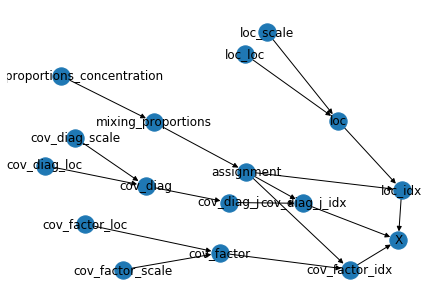

In [12]:
nx.draw(mixture, with_labels=True)

In [13]:
nx.get_node_attributes(mixture, 'plates')

{'cov_diag_loc': ['C'],
 'cov_diag_scale': ['C'],
 'cov_factor_loc': ['C'],
 'cov_factor_scale': ['C'],
 'cov_factor': ['C'],
 'X': ['N'],
 'cov_diag': ['C'],
 'cov_diag_j': ['C'],
 'loc': ['C'],
 'assignment': ['N'],
 'cov_factor_idx': ['N'],
 'cov_diag_j_idx': ['N'],
 'loc_idx': ['N']}

In [14]:
nx.get_node_attributes(mixture, 'shape')

{'cov_diag_loc': 'CD',
 'cov_diag_scale': 'CD',
 'cov_factor_loc': 'CDK',
 'cov_factor_scale': 'CDK',
 'mixing_proportions_concentration': 'C',
 'loc_loc': 'CD',
 'loc_scale': 'CD'}

In [15]:
#generate_Model_class(marg_factor)
generate_Model_class(mixture)

In [16]:
from model import DAGModel

In [17]:
pyro.clear_param_store()
N = 5000
D = 2
K = 4
C = 5
dagmodel = DAGModel(torch.zeros(N,D),K,C,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [18]:
dagmodel.param_shapes_and_support

{'loc_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'loc_prior_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'loc_loc_init_id': ((5, 2), Real()),
 'loc_prior_loc_init_id': ((5, 2), Real()),
 'mixing_proportions_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'mixing_proportions_prior_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'cov_factor_scale_init_id': ((5, 2, 4), GreaterThan(lower_bound=0.0)),
 'cov_factor_prior_scale_init_id': ((5, 2, 4), GreaterThan(lower_bound=0.0)),
 'cov_factor_loc_init_id': ((5, 2, 4), Real()),
 'cov_factor_prior_loc_init_id': ((5, 2, 4), Real()),
 'cov_diag_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'cov_diag_prior_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'cov_diag_loc_init_id': ((5, 2), Real()),
 'cov_diag_prior_loc_init_id': ((5, 2), Real())}

In [19]:
pyro.set_rng_seed(42)

In [20]:
dgp = dagmodel.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
true_locs = true_variables['loc_id']*20

new_dgp = pyro.poutine.condition(dgp, data={'loc_id':true_locs})
trace = pyro.poutine.trace(new_dgp).get_trace(torch.empty(N,D))

true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()
Xz = torch.cat([X,true_variables['assignment_id'].detach().float().unsqueeze(-1)],dim=-1)
Xzdata, Xztest_data = train_test_split(Xz)
data, train_assign = Xzdata[:,:-1],Xzdata[:,-1]
test_data, test_assign = Xztest_data[:,:-1],Xztest_data[:,-1]

In [21]:
X.shape

torch.Size([5000, 2])

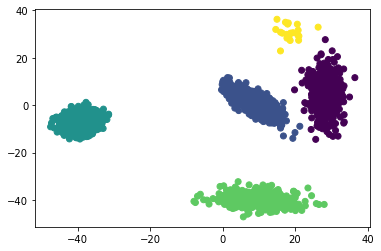

In [22]:
rand_idx = np.random.choice(D,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [23]:
config = dict(
        n_iter = 8000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [24]:
pyro.clear_param_store()
N = 1000
D = 2
K = 2
C = 1
student = DAGModel(torch.zeros(N,D),K,C,N,'id')
student.param_init['mixing_proportions_prior_concentration_init' + '_id'] *= 10

In [25]:
telemetry = inference(student, data, test_data, config=config)



NLL after 0/8000 iterations is 47.84524917602539
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/home/folzd/anaconda3/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py:419: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


.............................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 1000/8000 iterations is 11.19223690032959


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 1500/8000 iterations is 8.8823471069

In [26]:
config['telemetry'] = telemetry
config['n_iter'] = 2000

In [27]:
telemetry2 = inference(student, data, test_data, config=config)

Continuing from previous inference run.


NLL after 8000/10000 iterations is 8.580059051513672


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 8500/10000 iterations is 8.57083511352539


............................................................................................................................................................................................................................................................................................................................................................

In [28]:
student.sample_posterior_predictive(data.shape[0])

In [29]:
student.batch_size = 1
foo = student.posterior_predictive(data)
student.batch_size = 32

In [30]:
%matplotlib inline

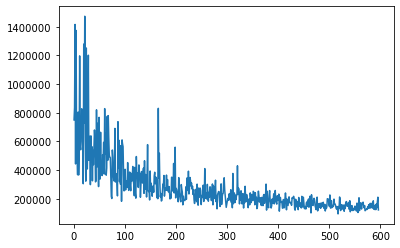

In [31]:
plt.plot(telemetry['loss'])

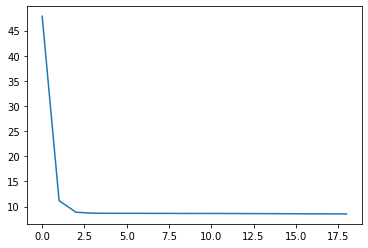

In [32]:
plt.plot(telemetry['MNLL'])

In [33]:
foo['obs'].shape

torch.Size([4500, 1, 2])

In [34]:
foo['assignment_id'].shape

torch.Size([4500, 1])

In [35]:
def compute_assignments(data, posterior_samples):
    _id = list(posterior_samples.keys())[0].split('_')[-1]
    n_posterior_samples,C,D = posterior_samples['loc_'+_id].shape

    n_posterior_samples = 200
    # get component distributions
    components = dist.LowRankMultivariateNormal(posterior_samples['loc_'+_id][:n_posterior_samples],posterior_samples['cov_factor_'+_id][:n_posterior_samples],posterior_samples['cov_diag_'+_id][:n_posterior_samples])

    # find log_prob of every datapoint under each component, for all posterior samples
    responsibilities = components.log_prob(data.unsqueeze(-2).unsqueeze(-2))

    greatest_responsibility,most_responsible = responsibilities.max(dim=-1)

    return most_responsible.sum(1)>n_posterior_samples/C

#### Plot color-coded true data against predictive posterior sample

In [69]:
%matplotlib qt
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

TypeError: tuple indices must be integers or slices, not str

#### Plot color-coded predictive posterior sample

In [37]:
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,0].squeeze().T.detach())

#### Plot true data color-coded by predictive posterior sample

In [38]:
plt.scatter(*data[:,rand_idx].T,c=compute_assignments(data, foo))

## Make random split

In [39]:
def split_along_eigvector(mean, cov):
    eigvals, eigvecs = torch.eig(cov, eigenvectors=True)
    # cov = M @ M.T
    # where M = eigvecs @ torch.diag(torch.sqrt(eigvals[:,0]))
    weighted_eigvecs = torch.matmul(torch.diag(torch.sqrt(eigvals[:,0])),eigvecs.T)
    # sample eigevector with probability proportional to eigenvalue
    softmax = torch.nn.Softmax(dim=0)
    v = np.random.choice(eigvals.shape[0],p=softmax(torch.abs(eigvals[:,0])).numpy())
    vec = weighted_eigvecs[v]
    eigvals0 = eigvals.clone()
    eigvals0[v,0] = eigvals0[v,0]/2
    # shift means by weighted eigenvector
    # scale factor by 1/2
    return torch.stack([mean+vec,mean-vec]), torch.matmul(eigvecs,torch.diag(torch.sqrt(eigvals0[:,0])))

In [ ]:
[0,1]

In [ ]:
[0,1,2]

In [156]:
def init_split_move(student, teacher, split_cluster_idx):
    """
    Replaces all tensors in student.param_init by those in teacher.params,
    except for those that define the splitted cluster
    """
    c = split_cluster_idx
    
    mean = teacher.params['loc_loc_'+teacher._id][c]
    variances = torch.exp(teacher.params['cov_diag_loc_'+teacher._id][c]+teacher.params['cov_diag_scale_'+teacher._id][c]**2/2)
    cov = torch.matmul(teacher.params['cov_factor_loc_'+teacher._id][c],teacher.params['cov_factor_loc_'+teacher._id][c].T) + torch.diag(variances)
    
    new_means, new_cov_factor = split_along_eigvector(mean, cov)    
    
    for param_name, param_value in student.param_init.items():
        teacher_param_name = param_name.replace('init_'+student._id, teacher._id)
        for component,_ in enumerate(teacher.params[teacher_param_name]):
            if component == c:
                student.param_init['loc_loc_init_'+student._id][component] = new_means[0]
                student.param_init['loc_loc_init_'+student._id][-1] = new_means[1]
                student.param_init['loc_prior_loc_init_'+student._id][component] = new_means[0]
                student.param_init['loc_prior_loc_init_'+student._id][-1] = new_means[1]

                student.param_init['cov_factor_loc_init_'+student._id][component] = new_cov_factor
                student.param_init['cov_factor_loc_init_'+student._id][-1] = new_cov_factor
                student.param_init['cov_factor_prior_loc_init_'+student._id][component] = new_cov_factor
                student.param_init['cov_factor_prior_loc_init_'+student._id][-1] = new_cov_factor
                
                teacher_mixing = 'mixing_proportions_concentration_'+teacher._id
                student.param_init['mixing_proportions_concentration_init_'+student._id][component] = teacher.params[teacher_mixing][component]/2
                student.param_init['mixing_proportions_concentration_init_'+student._id][-1] = teacher.params[teacher_mixing][component]/2
                next
            else:
                student.param_init[param_name][component] = teacher.params[teacher_param_name][component]
    return mean, cov, new_means, new_cov_factor

In [41]:
def split_move(teacher, _id):
    C = teacher.C + 1
    pyro.clear_param_store()
    student = DAGModel(torch.zeros(N,D),K,C,N,_id)
    # sample cluster to be split
    # probabilities prop to cluster size?
    split_cluster = np.random.choice(teacher.C)
    foo = init_split_move(student, teacher, split_cluster)
    config['n_iter'] = 1
    config['telemetry'] = None
    telemetry = inference(student, data, test_data, config=config)
    return student, foo

In [127]:
compute_assignments(data, new_student_ppc)

tensor([ True,  True, False,  ..., False, False, False])

In [ ]:
new_student

In [42]:
new_student, foo = split_move(student, 'new')

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


NLL after 0/1 iterations is 8.417669296264648
.
Converged in 1 iterations.



In [43]:
new_student.sample_posterior_predictive(data.shape[0])

new_student.batch_size = 1
new_student_ppc = new_student.posterior_predictive(data)
new_student.batch_size = 32

In [123]:
%matplotlib qt
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [124]:
plt.scatter(*new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=new_student_ppc['assignment_'+new_student._id][:,0].squeeze().T.detach())

In [126]:
plt.scatter(*data[:,rand_idx].T,c=compute_assignments(data, new_student_ppc))

In [47]:
config['n_iter'] = 10000
config['telemetry'] = telemetry

In [48]:
telemetry = inference(new_student, data, test_data, config=config)

Continuing from previous inference run.


NLL after 10000/20000 iterations is 8.411011695861816


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 10500/20000 iterations is 7.556303977966309


.........................................................................................................................................................................................................................................................................................................................................................

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 17500/20000 iterations is 6.4604902267456055


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [49]:
plt.plot(telemetry['MNLL'])

In [50]:
new_student.sample_posterior_predictive(data.shape[0])

In [51]:
new_student.batch_size = 1
new_student_ppc = new_student.posterior_predictive(data)
new_student.batch_size = 32

In [ ]:
_, counts = np.unique(train_assign.squeeze(), return_counts=True)

counts/sum(counts)

In [98]:
plt.figure()
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [97]:
new_student.params['loc_loc_new']

tensor([[ 14.4395,  -7.5016],
        [-39.4309,  -7.0214]])

In [100]:
new_student.params['loc_loc_new'][1]

tensor([-39.4309,  -7.0214])

In [74]:
plt.scatter(*new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=new_student_ppc['assignment_'+new_student._id][:,0].squeeze().T.detach())

In [75]:
plt.scatter(*data[:,rand_idx].T,c=compute_assignments(data, new_student_ppc))

In [157]:
new_new_student, foo = split_move(new_student, 'new1')



NLL after 0/1 iterations is 6.590758323669434
.
Converged in 1 iterations.



In [158]:
new_new_student.param_init

{'loc_scale_init_new1': tensor([[0.7307, 0.8151],
         [0.0203, 0.0217],
         [0.4669, 0.3986]]),
 'loc_prior_scale_init_new1': tensor([[0.7548, 0.4175],
         [0.0229, 0.0318],
         [0.5145, 0.8513]]),
 'loc_loc_init_new1': tensor([[ 11.0272, -26.3538],
         [-39.4209,  -7.0314],
         [ 17.8519,  11.3307]], requires_grad=True),
 'loc_prior_loc_init_new1': tensor([[ 11.0072, -26.3338],
         [-39.4373,  -7.0307],
         [ 17.8719,  11.3507]], requires_grad=True),
 'mixing_proportions_concentration_init_new1': tensor([nan, nan, nan]),
 'mixing_proportions_prior_concentration_init_new1': tensor([8.5387e-01, 8.4472e+04, 4.9927e-01]),
 'cov_factor_scale_init_new1': tensor([[[0.4265, 0.2836],
          [0.6746, 1.1231]],
 
         [[0.0168, 0.0271],
          [0.0243, 0.0234]],
 
         [[0.5908, 0.2953],
          [0.1934, 0.5454]]]),
 'cov_factor_prior_scale_init_new1': tensor([[[1.0150, 0.1183],
          [2.5924, 2.1440]],
 
         [[0.0213, 0.0313],
   

In [159]:
mean, cov, new_means, new_cov_factor = foo
ax = plt.axes()
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(x,y)
plt.xlim(-30,50)
plt.ylim(-140,140)
confidence_ellipse(mean,cov,ax,3.0,'b',alpha=.5)
confidence_ellipse(new_means[0],new_cov_factor@new_cov_factor.T,ax,3.0,'r',alpha=.5)
confidence_ellipse(new_means[1],new_cov_factor@new_cov_factor.T,ax,3.0,'r',alpha=.5)
#confidence_ellipse(student.params['loc_loc_id'][c].numpy(),np.cov(x,y),ax,3.0,'r',alpha=.5)
#ax.arrow(*student.params['loc_loc_id'][c], *weighted_eigvecs[0], head_width=0.5, head_length=0.7, fc='lightblue', ec='black')
#ax.arrow(*student.params['loc_loc_id'][c], *weighted_eigvecs[1], head_width=0.5, head_length=0.7, fc='lightblue', ec='black')

In [160]:
new_new_student.sample_posterior_predictive(data.shape[0])

new_new_student.batch_size = 1
new_new_student_ppc = new_new_student.posterior_predictive(data)
new_new_student.batch_size = 32

In [163]:
plt.figure()
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*new_new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [162]:
plt.scatter(*new_new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=new_new_student_ppc['assignment_'+new_new_student._id][:,0].squeeze().T.detach())

In [165]:
config['n_iter'] = 5000
config['telemetry'] = telemetry

In [166]:
telemetry = inference(new_new_student, data, test_data, config=config)

Continuing from previous inference run.
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [167]:
new_new_student.sample_posterior_predictive(data.shape[0])

new_new_student.batch_size = 1
new_new_student_ppc = new_new_student.posterior_predictive(data)
new_new_student.batch_size = 32

In [172]:
plt.figure()
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*new_new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [174]:
plt.figure()
plt.scatter(*new_new_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=new_new_student_ppc['assignment_'+new_new_student._id][:,0].squeeze().T.detach())

In [190]:
new_2_student, foo = split_move(new_student, 'new2')



NLL after 0/1 iterations is 6.560641765594482
.
Converged in 1 iterations.



In [197]:
new_2_student, foo = split_move(new_student, 'new2')



NLL after 0/1 iterations is 6.503592491149902
.
Converged in 1 iterations.



In [198]:
new_2_student.sample_posterior_predictive(data.shape[0])

new_2_student.batch_size = 1
new_2_student_ppc = new_2_student.posterior_predictive(data)
new_2_student.batch_size = 32

In [199]:
plt.figure()
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*new_2_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [200]:
plt.scatter(*new_2_student_ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=new_2_student_ppc['assignment_'+new_2_student._id][:,0].squeeze().T.detach())